In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader

# Define a GNN with 2 hidden layers
class GNNModel(nn.Module):
    def __init__(self, num_features, hidden_channels, num_feats_y):
        super().__init__()
        self.conv1, self.conv2 = GCNConv(num_features, hidden_channels[0]), GCNConv(hidden_channels[0], hidden_channels[1])
        self.fc1, self.fc2 = nn.Linear(hidden_channels[1], hidden_channels[0]), nn.Linear(hidden_channels[0], num_feats_y)

    def forward(self, x, edge_index):
        x = F.leaky_relu(self.conv1(x, edge_index))
        x = F.leaky_relu(self.conv2(x, edge_index))
        x = F.leaky_relu(self.fc1(x))
        return self.fc2(x)

# Graph Configuration
nx, xa = 25, 10
x_grid = torch.linspace(0, xa, nx)
p1, p2 = torch.sin(2 * torch.pi * x_grid / xa), torch.cos(2 * torch.pi * x_grid / xa)

# Create adjacency matrix & edge index
diff = torch.sqrt((p1.repeat(nx, 1).T - p1) ** 2 + (p2.repeat(nx, 1).T - p2) ** 2)
edge_index = (diff < 0.5).float().nonzero(as_tuple=False).t().contiguous()

# Create node features & labels
data = Data(x=torch.cat((p1.unsqueeze(1), p2.unsqueeze(1)), dim=1), y=torch.randint(0, 2, (nx, 1)).float(), edge_index=edge_index)

# Initialize & print model
model = GNNModel(num_features=2, hidden_channels=[8, 16], num_feats_y=1)
print(model)


GNNModel(
  (conv1): GCNConv(2, 8)
  (conv2): GCNConv(8, 16)
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Define a GNN with 2 hidden layers
class GNNModel(nn.Module):
    def __init__(self, num_features, hidden_channels, num_feats_y):
        super(GNNModel, self).__init__()

        # Graph Convolutional Layers (Message Passing)
        self.conv1 = GCNConv(num_features, hidden_channels[0])
        self.conv2 = GCNConv(hidden_channels[0], hidden_channels[1])

        # Fully Connected Layers (MLP Head)
        self.fc1 = nn.Linear(hidden_channels[1], hidden_channels[0])
        self.fc2 = nn.Linear(hidden_channels[0], num_feats_y)

    def forward(self, x, edge_index):
        # Message Passing with GCN Layers
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)
        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)

        # Fully Connected Layers
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)

        return x

# Graph Configuration
nx = 25  # Number of nodes
xa = 10  # Domain size

# Create adjacency matrix
x_grid = torch.linspace(0, xa, nx)
p1 = torch.sin(2 * torch.pi * x_grid / xa)
p2 = torch.cos(2 * torch.pi * x_grid / xa)
p1m = p1.repeat(nx, 1).T
p2m = p2.repeat(nx, 1).T
diff = torch.sqrt((p1m - p1m.T) ** 2 + (p2m - p2m.T) ** 2)
adjm = (diff < 0.5).float()  # Adjacency matrix
edge_index = adjm.nonzero(as_tuple=False).t().contiguous()

# Create node features (x) and labels (y)
x_features = torch.cat((p1.unsqueeze(1), p2.unsqueeze(1)), dim=1)  # Shape: (25, 2)
y_labels = torch.randint(0, 2, (nx, 1)).float()  # Random binary classification labels

# Create `torch_geometric.data.Data` object
data = Data(x=x_features, y=y_labels, edge_index=edge_index)

# ---------------------
#Initialize Model
# ---------------------
hidden_channels = [8, 16]  # Two hidden layers
num_features_x = 2  # Two input features
num_output_features = 1  # One output feature
model = GNNModel(num_features_x, hidden_channels, num_output_features)

# Print model architecture
print(model)

GNNModel(
  (conv1): GCNConv(2, 8)
  (conv2): GCNConv(8, 16)
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [3]:
# Count total edges
num_edges = edge_index.shape[1]  # Number of edges (columns in edge_index)
print(f"Total edges in the graph: {num_edges}")

# Compute degree of each node (how many neighbors per node)
degree_per_node = torch.bincount(edge_index[0])  # Count occurrences of each node in source nodes
print(f"Average number of neighbors per node: {degree_per_node.float().mean().item()}")
print(f"Minimum neighbors: {degree_per_node.min().item()}, Maximum neighbors: {degree_per_node.max().item()}")

# Print degree of first few nodes
for i in range(min(10, nx)):  # Print up to 10 nodes
    print(f"Node {i} has {degree_per_node[i].item()} neighbors")


Total edges in the graph: 79
Average number of neighbors per node: 3.1600000858306885
Minimum neighbors: 3, Maximum neighbors: 4
Node 0 has 4 neighbors
Node 1 has 4 neighbors
Node 2 has 3 neighbors
Node 3 has 3 neighbors
Node 4 has 3 neighbors
Node 5 has 3 neighbors
Node 6 has 3 neighbors
Node 7 has 3 neighbors
Node 8 has 3 neighbors
Node 9 has 3 neighbors


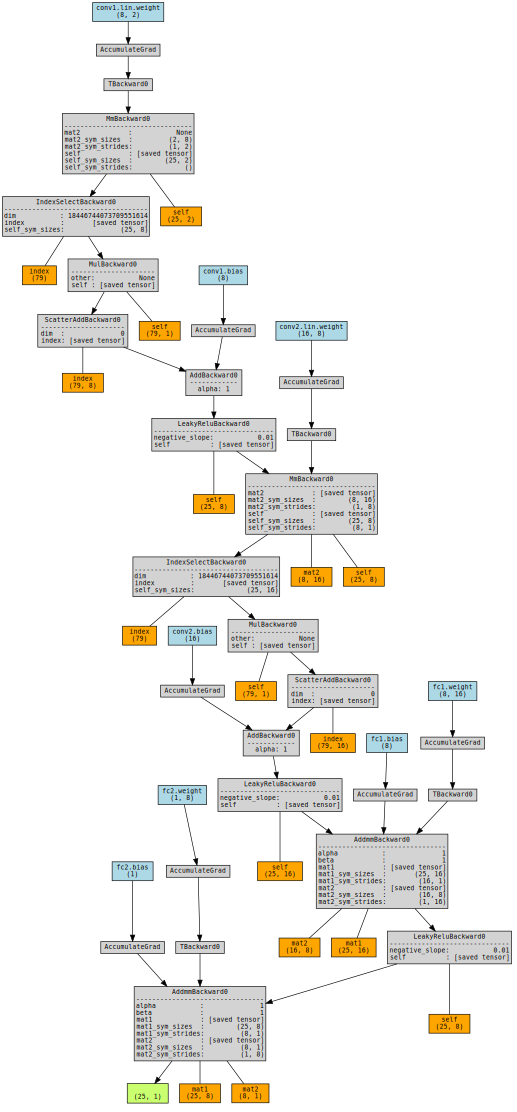

In [4]:
import torch
from torchviz import make_dot

# Forward pass to generate graph visualization
y_pred = model(data.x, data.edge_index)

# Modify torchviz to include input features
dot = make_dot(y_pred, 
               params={**dict(model.named_parameters()), 'Input Features': data.x}, 
               show_attrs=True,  # Show tensor attributes (e.g., shape)
               show_saved=True   # Show saved intermediate tensors
              )

# Render the graph
dot.render("gnn_graph", format="png", cleanup=True)
dot


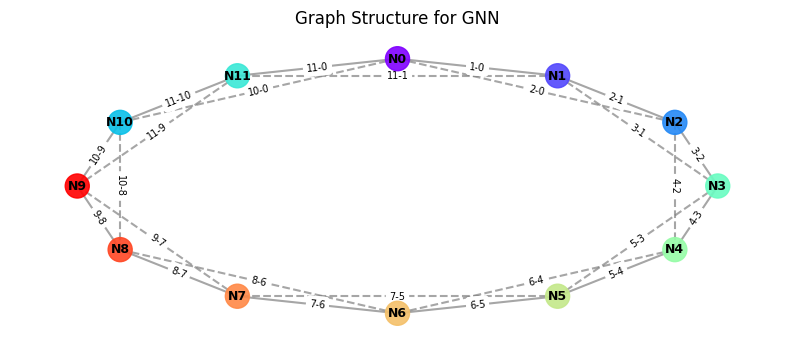

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_gnn(edge_index, num_nodes, a=5, b=3):
    """
    Visualizes the graph structure used in the GNN with 4-neighbor periodic connectivity.
    
    - Positions nodes **on an ellipse** using parametric equations.
    - Uses **curved edges** for better visibility.
    """
    G = nx.Graph()  # Undirected graph for visualization

    # Add edges from edge_index
    edges = edge_index.t().tolist()  # Convert tensor to list of edges
    G.add_edges_from(edges)

    # Generate parametric elliptical positions
    tau_values = np.linspace(0, 2 * np.pi, num_nodes, endpoint=False)  # Equally spaced angles
    x_positions = a * np.sin(tau_values)  # Elliptical x-values
    y_positions = b * np.cos(tau_values)  # Elliptical y-values

    pos = {i: (x_positions[i], y_positions[i]) for i in range(num_nodes)}

    # Node colors based on index
    node_colors = plt.cm.rainbow(np.linspace(0, 1, num_nodes))

    plt.figure(figsize=(a, b))  # Adjusted for better visualization

    # Draw nodes with rainbow colors
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, alpha=0.9)

    # Draw edges (Use `nx.draw_networkx_edges` with curved paths for better visibility)
    curved_edges = [(u, v) for u, v in G.edges() if abs(u - v) > 1 and not (u == 0 and v == num_nodes - 1)]  # Curved edges for longer jumps
    straight_edges = [(u, v) for u, v in G.edges() if abs(u - v) == 1 or (u == 0 and v == num_nodes - 1)]  # Direct neighbors + periodic edges

    # Draw straight and curved edges separately
    nx.draw_networkx_edges(G, pos, edgelist=straight_edges, edge_color="gray", width=1.5, alpha=0.7)
    nx.draw_networkx_edges(G, pos, edgelist=curved_edges, edge_color="gray", width=1.5, alpha=0.7, style="dashed")

    # Annotate nodes
    labels = {i: f"N{i}" for i in range(num_nodes)}
    nx.draw_networkx_labels(G, pos, labels, font_size=9, font_weight="bold")

    # Add edge labels (showing node connections)
    edge_labels = {(u, v): f"{u}-{v}" for u, v in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, font_color="black")

    plt.title(f"Graph Structure for GNN")
    plt.axis("off")
    plt.savefig("gnn_graph.png", bbox_inches="tight")
    plt.show()

# ---------------------
# ✅ FIX: Ensure each node connects to 4 neighbors + periodicity
# ---------------------

nx_nodes = 12  # Number of nodes
a, b = 10, 4  # Ellipse parameters

# Compute adjacency with 4-neighbor connectivity (2 left, 2 right) and periodic boundary conditions
adjm = torch.zeros((nx_nodes, nx_nodes), dtype=torch.float)

for i in range(nx_nodes):
    # Standard left and right neighbors (with wrap-around)
    adjm[i, (i - 1) % nx_nodes] = 1  # Connect to left neighbor (wraps around)
    adjm[i, (i - 2) % nx_nodes] = 1  # Connect to second left neighbor (wraps around)
    adjm[i, (i + 1) % nx_nodes] = 1  # Connect to right neighbor (wraps around)
    adjm[i, (i + 2) % nx_nodes] = 1  # Connect to second right neighbor (wraps around)

# Convert adjacency matrix to edge index format
edge_index = adjm.nonzero(as_tuple=False).t().contiguous()

# Visualize the periodic graph with proper elliptical positioning
visualize_gnn(edge_index, num_nodes=nx_nodes, a=a, b=b)


In [6]:
edge_index

tensor([[ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,  4,
          4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,
          9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11],
        [ 1,  2, 10, 11,  0,  2,  3, 11,  0,  1,  3,  4,  1,  2,  4,  5,  2,  3,
          5,  6,  3,  4,  6,  7,  4,  5,  7,  8,  5,  6,  8,  9,  6,  7,  9, 10,
          7,  8, 10, 11,  0,  8,  9, 11,  0,  1,  9, 10]])

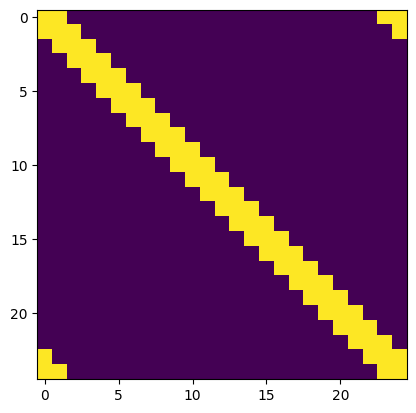

In [7]:
plt.imshow(diff)
plt.savefig("diff_matrix.png")

plt.imshow(diff<0.5)
plt.savefig("diff_matrix_smaller_const.png")

Epoch 1, Train Loss: 0.4964637692485537, Test Loss: 0.47880476287433077
Epoch 101, Train Loss: 0.15309821548206465, Test Loss: 0.1514423138328961
Epoch 201, Train Loss: 0.14963119530252048, Test Loss: 0.14839153098208563
Epoch 301, Train Loss: 0.1370079360370125, Test Loss: 0.13628831239683287
Epoch 401, Train Loss: 0.06136760661112411, Test Loss: 0.0752081326874239
Epoch 501, Train Loss: 0.03436164251927819, Test Loss: 0.03970200229170067
Epoch 601, Train Loss: 0.012262578122317791, Test Loss: 0.01464179517435176
Epoch 701, Train Loss: 0.004152890402890209, Test Loss: 0.0037991952018014024
Epoch 801, Train Loss: 0.002364182659740826, Test Loss: 0.003170510970189103
Epoch 901, Train Loss: 0.011834615242800542, Test Loss: 0.01846981160010078
Epoch 1001, Train Loss: 0.0005114342269994918, Test Loss: 0.00044361049211667184
Epoch 1101, Train Loss: 0.0003717545623658225, Test Loss: 0.00035653659662265066
Epoch 1201, Train Loss: 0.00030038898694328964, Test Loss: 0.00021852868667338043
Epoch

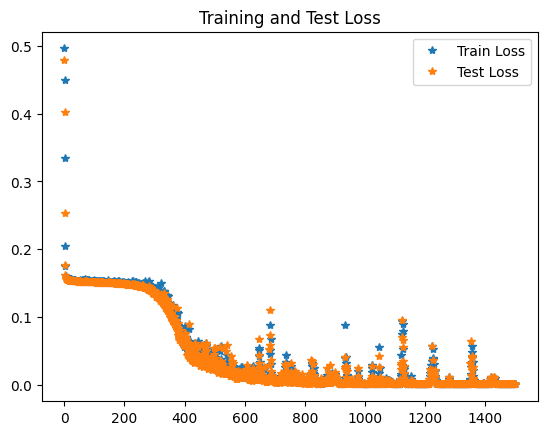

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.data as geom_data
import torch_geometric.nn as geom_nn

# Set random seed
torch.manual_seed(0)

# Define parameters
xa, nx, nt, v = 10, 25, 15, 0.6

# Create grid and function data
x_grid = np.linspace(0, xa, nx + 1)[:-1]
z = np.zeros([nt, nx])
for j in range(nt):
    z[j, :] = np.sin((2 * np.pi / xa) * x_grid - v * j)

# Create adjacency matrix
p1 = np.sin(2 * np.pi * x_grid / xa)
p2 = np.cos(2 * np.pi * x_grid / xa)
p1m, p2m = np.tile(p1, (nx, 1)).T, np.tile(p2, (nx, 1)).T
diff = np.sqrt((p1m - p1m.T) ** 2 + (p2m - p2m.T) ** 2)
adjm = (diff < 0.5).astype(int)
edge_index = torch.tensor(np.array(np.nonzero(adjm)), dtype=torch.long)

# Split data into training and testing
X_train, Y_train = z[:-1], z[1:]
X_test, Y_test = z[:-1], z[1:]

# Create feature tensors and data loader
features_tmp2 = torch.tensor(np.arange(1, nx + 1) / nx, dtype=torch.float).unsqueeze(1)
train_list, test_list = [], []
for k in range(X_train.shape[0]):
    features_k_tmp1 = torch.tensor(X_train[k, :], dtype=torch.float).unsqueeze(1)
    features_k = torch.cat((features_k_tmp1, features_tmp2), dim=1)
    labels_k = torch.tensor(Y_train[k, :], dtype=torch.float).unsqueeze(1)
    data = geom_data.Data(x=features_k, y=labels_k, edge_index=edge_index)
    train_list.append(data)

for k in range(X_test.shape[0]):
    features_k_tmp1 = torch.tensor(X_test[k, :], dtype=torch.float).unsqueeze(1)
    features_k = torch.cat((features_k_tmp1, features_tmp2), dim=1)
    labels_k = torch.tensor(Y_test[k, :], dtype=torch.float).unsqueeze(1)
    data = geom_data.Data(x=features_k, y=labels_k, edge_index=edge_index)
    test_list.append(data)

# Create DataLoaders for training and testing
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader  # neuer Import

train_loader = DataLoader(train_list, batch_size=1, shuffle=True)
test_loader = DataLoader(test_list, batch_size=1, shuffle=False)

# Define the GNN model
class GNNModel(nn.Module):
    def __init__(self, num_features, hidden_channels, num_feats_y):
        super(GNNModel, self).__init__()
        self.conv1 = geom_nn.GCNConv(num_features, hidden_channels[0])
        self.conv2 = geom_nn.GCNConv(hidden_channels[0], hidden_channels[1])
        self.conv3 = geom_nn.GCNConv(hidden_channels[1], hidden_channels[2])
        self.conv4 = geom_nn.GCNConv(hidden_channels[2], hidden_channels[3])
        self.fc1 = nn.Linear(hidden_channels[3], hidden_channels[2])
        self.fc2 = nn.Linear(hidden_channels[2], hidden_channels[0])
        self.fc3 = nn.Linear(hidden_channels[0], num_feats_y)

    def forward(self, x, edge_index):
        x = F.leaky_relu(self.conv1(x, edge_index))
        x = F.leaky_relu(self.conv2(x, edge_index))
        x = F.leaky_relu(self.conv3(x, edge_index))
        x = F.leaky_relu(self.conv4(x, edge_index))
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)

# Initialize model, optimizer, and criterion
model = GNNModel(num_features=2, hidden_channels=[4 * nt, 4 * nt, 4 * nt, 4 * nt], num_feats_y=1)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0)
criterion = nn.MSELoss()

# Training loop
epochs = 1500
train_mse, test_mse = [], []
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    train_mse_tmp = []
    for batch in train_loader:
        optimizer.zero_grad()
        output = model(batch.x, batch.edge_index)
        loss = criterion(output, batch.y)
        train_mse_tmp.append(loss.item())
        loss.backward()
        optimizer.step()
    train_mse.append(np.mean(train_mse_tmp))

    model.eval()
    test_mse_tmp = []
    for batch in test_loader:
        y_pred = model(batch.x, batch.edge_index)
        test_loss = criterion(y_pred, batch.y)
        test_mse_tmp.append(test_loss.item())
    test_mse.append(np.mean(test_mse_tmp))

    if epoch % 100 == 0:
        print(f'Epoch {epoch + 1}, Train Loss: {train_mse[epoch]}, Test Loss: {test_mse[epoch]}')

# Plot training and test MSE
plt.plot(np.arange(epochs), train_mse, '*', label='Train Loss')
plt.plot(np.arange(epochs), test_mse, '*', label='Test Loss')
plt.legend()
plt.title("Training and Test Loss")
plt.savefig("gnn_loss_curve.png")
plt.show()

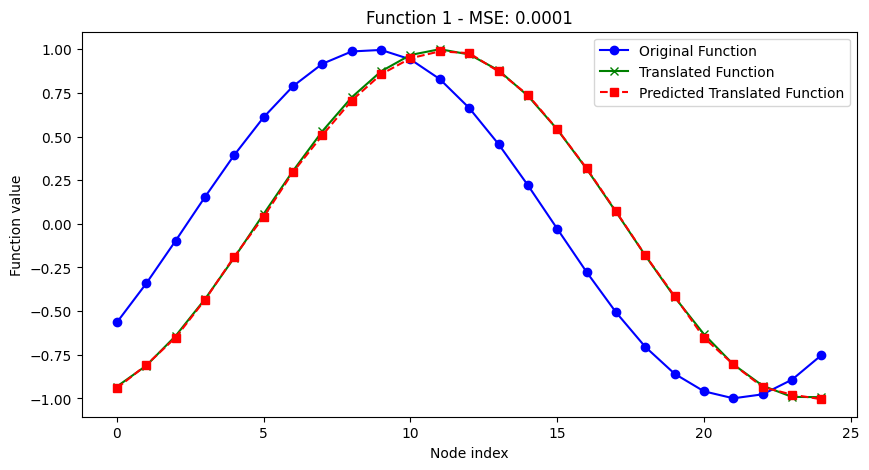

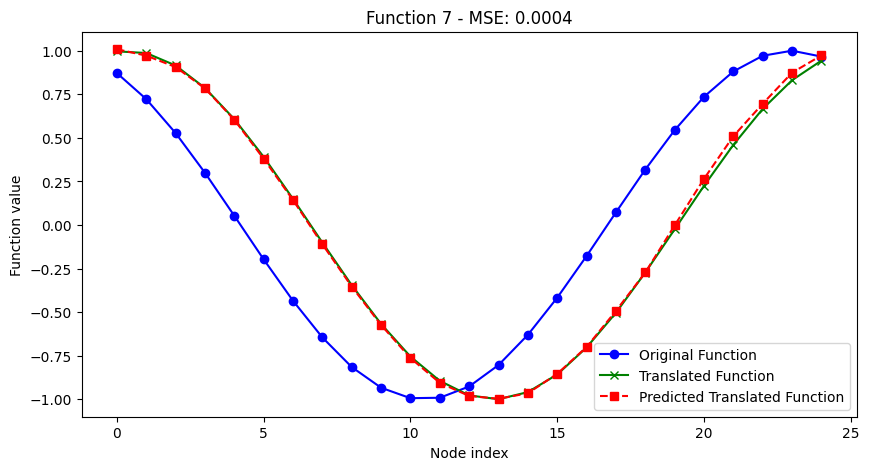

Average Test MSE: 0.0003


In [9]:
# Test loop: Compare original, translated, and predicted functions
model.eval()
test_mse_tmp = []
ni=1  # counter for images

# Select a few test cases
test_cases = np.random.choice(range(len(X_train) - 1), size=2, replace=False)  # Ensure there's an X_train[idx+1]

for idx in test_cases:
    # Get a batch from the selected test case
    original_func = X_train[idx]  # Original function at time step t
    translated_func = X_train[idx + 1]  # Translated function at time step t+1 (next time step)
    input_features = train_list[idx].x
    
    # Predict with the model
    with torch.no_grad():
        predicted_func = model(input_features, train_list[idx].edge_index).numpy().flatten()

    # Compute MSE for this test case
    mse = np.mean((translated_func - predicted_func) ** 2)
    test_mse_tmp.append(mse)

    # Plot comparison for this test case (Original, Translated, and Predicted)
    plt.figure(figsize=(10, 5))
    plt.plot(original_func, label="Original Function", linestyle='-', marker='o', color='blue')
    plt.plot(translated_func, label="Translated Function", linestyle='-', marker='x', color='green')
    plt.plot(predicted_func, label="Predicted Translated Function", linestyle='--', marker='s', color='red')
    plt.title(f"Function {idx} - MSE: {mse:.4f}")
    plt.legend()
    plt.xlabel('Node index')
    plt.ylabel('Function value')
    plt.savefig(f"gnn_test_{ni}.png")
    ni+=1
    plt.show()

# Calculate the average MSE over selected test cases
avg_test_mse = np.mean(test_mse_tmp)
print(f"Average Test MSE: {avg_test_mse:.4f}")


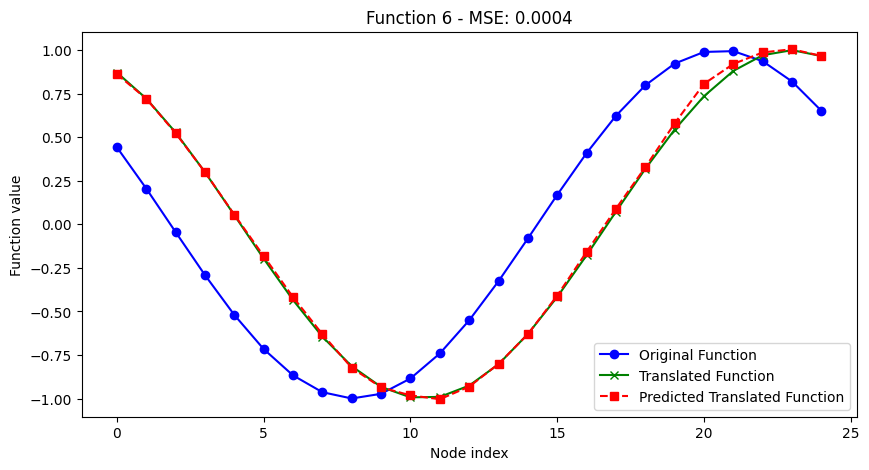

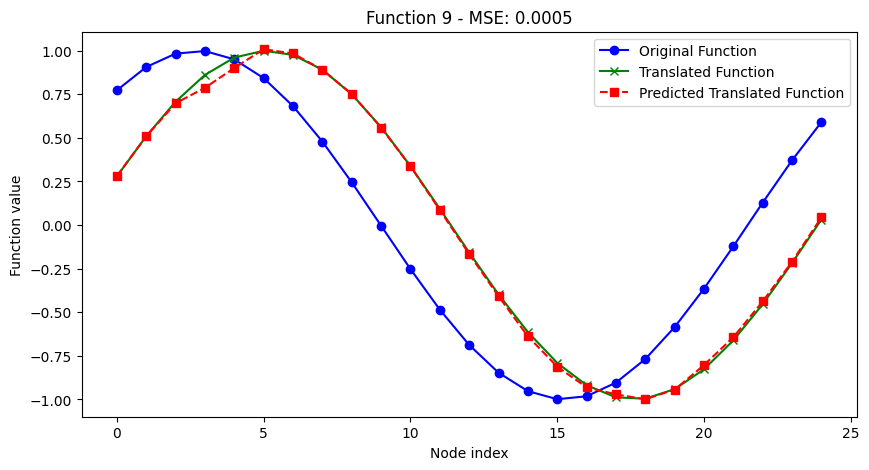

Average Test MSE: 0.0005


In [11]:
# Test loop: Compare original, translated, and predicted functions on the test dataset
model.eval()
test_mse_tmp = []
ni = 1  # Counter for images

# Select a few test cases from the test dataset
test_cases = np.random.choice(range(len(X_test) - 1), size=2, replace=False)  # Ensure there's an X_test[idx+1]

for idx in test_cases:
    # Get a batch from the selected test case from the test dataset
    original_func = X_test[idx]  # Original function at time step t
    translated_func = X_test[idx + 1]  # Translated function at time step t+1 (next time step)
    input_features = test_list[idx].x  # Get input features from the test data
    
    # Predict with the model
    with torch.no_grad():
        predicted_func = model(input_features, test_list[idx].edge_index).numpy().flatten()

    # Compute MSE for this test case
    mse = np.mean((translated_func - predicted_func) ** 2)
    test_mse_tmp.append(mse)

    # Plot comparison for this test case (Original, Translated, and Predicted)
    plt.figure(figsize=(10, 5))
    plt.plot(original_func, label="Original Function", linestyle='-', marker='o', color='blue')
    plt.plot(translated_func, label="Translated Function", linestyle='-', marker='x', color='green')
    plt.plot(predicted_func, label="Predicted Translated Function", linestyle='--', marker='s', color='red')
    plt.title(f"Function {idx} - MSE: {mse:.4f}")
    plt.legend()
    plt.xlabel('Node index')
    plt.ylabel('Function value')
    plt.savefig(f"gnn_test_tds_{ni}.png")
    ni += 1
    plt.show()

# Calculate the average MSE over selected test cases
avg_test_mse = np.mean(test_mse_tmp)
print(f"Average Test MSE: {avg_test_mse:.4f}")
